In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import tensorflow
tensorflow.__version__

In [1]:
import numpy as np
from os.path import join
from matplotlib import pyplot as plt
from cv2 import rectangle
import cv2
import matplotlib.patches as patches
import pydicom


import pandas as pd
import tensorflow
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input as mobile_net_preprocessing
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocessing
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D,Conv2DTranspose,BatchNormalization,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

import re

import os
# Initialize the random number generator
# import random
# random.seed(0)
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

#### reading the splitted data

In [2]:
base_file_path = os.path.join(os.getcwd(), 'final_pre_processed_data','locolization_data')
train_data = pd.read_csv(os.path.join(base_file_path,"train.csv"))
validation_data = pd.read_csv(os.path.join(base_file_path,"validation.csv"))
test_data = pd.read_csv(os.path.join(base_file_path,"test.csv"))
train_folder_name:str = 'stage_2_train_images'
train_folder_path:str = os.path.join('Capstone_CV_Project',
                                     'raw_data',
                                     train_folder_name)

print(f'The size of training data {train_data.shape}')
print(f'The size of validation data {validation_data.shape}')
print(f'The size of test data {test_data.shape}')

The size of training data (4208, 10)
The size of validation data (1623, 10)
The size of test data (181, 10)


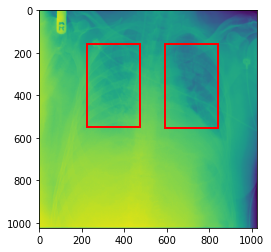

Masks!!


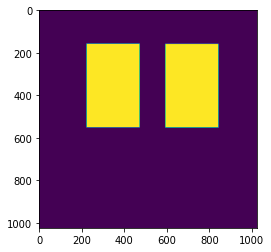

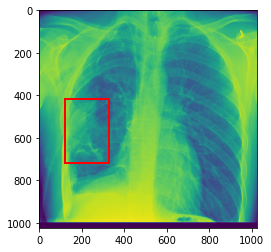

Masks!!


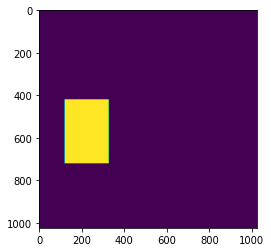

In [3]:
def get_coordinates_string(coordinates):
    #coordinates_preprocessing
    coordinates_list = re.findall(r'\d+',coordinates)
    coordinates_final_list = []
    count = 0
    for index in range(0,len(coordinates_list),2):
        coordinates_final_list.append(int(coordinates_list[index]))
        count+=1
    
    coordinates_final_list = [coordinates_final_list[index:index+4] for index in range(0, len(coordinates_final_list), 4)]
    return coordinates_final_list
    
no_samples = 2
for index in range(0,no_samples):
    pid = train_data.iloc[index]['Patient_ids']
    coordinates = train_data.iloc[index]['coordinates']
    no_rows = train_data.iloc[index]['No_rows']
    no_columns = train_data.iloc[index]['No_columns']
    coordinates = get_coordinates_string(coordinates)
    path_dicom = os.path.join(train_folder_path,pid+".dcm")
    dicom_obj:pydicom.dataset.FileDataset = pydicom.read_file(path_dicom)
    pixel_values = dicom_obj.pixel_array
    fig,ax = plt.subplots(1)
    masks = np.zeros((1024,1024))
    # Display the image
    ax.imshow(pixel_values)
    for coor in coordinates:
        x1 = coor[0]
        y1 = coor[1]
        x2 = coor[0]+coor[2]
        y2 = coor[1]+coor[3]
        rect = patches.Rectangle((coor[0], coor[1]), coor[2], coor[3], linewidth=2, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        masks[y1:y2, x1:x2] = 1
    
    plt.show()
    print('Masks!!')
    plt.imshow(masks)

samples after resizing

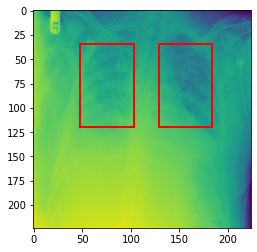

Masks!!


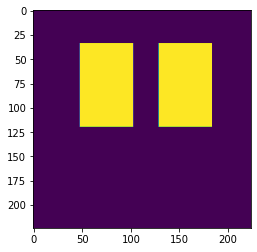

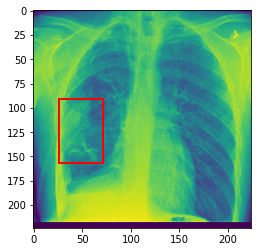

Masks!!


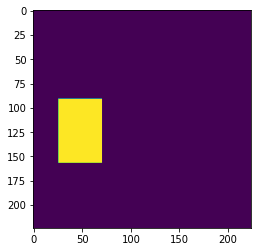

In [4]:
no_samples = 2
RESIZE_HEIGHT = RESIZE_WIDTH = 224  
for index in range(0,no_samples):
    pid = train_data.iloc[index]['Patient_ids']
    coordinates = train_data.iloc[index]['coordinates']
    no_rows = train_data.iloc[index]['No_rows']
    no_columns = train_data.iloc[index]['No_columns']
    coordinates = get_coordinates_string(coordinates)
    path_dicom = os.path.join(train_folder_path,pid+".dcm")
    dicom_obj:pydicom.dataset.FileDataset = pydicom.read_file(path_dicom)
    pixel_values = dicom_obj.pixel_array
    img_resized = cv2.resize(pixel_values, dsize=(RESIZE_HEIGHT,RESIZE_WIDTH), interpolation=cv2.INTER_CUBIC)
    fig,ax = plt.subplots(1)
    masks = np.zeros((RESIZE_HEIGHT,RESIZE_WIDTH))
    # Display the image
    ax.imshow(img_resized)
    for coor in coordinates:
        x1 = int(coor[0] * (RESIZE_WIDTH/no_columns))
        y1 = int(coor[1]*(RESIZE_HEIGHT/no_rows))
        x2 = int((coor[0]+coor[2])*(RESIZE_WIDTH/1024))
        y2 = int((coor[1]+coor[3])*(RESIZE_HEIGHT/1024))
        rect = patches.Rectangle((x1, y1), x2-x1,y2-y1 , linewidth=2, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        masks[y1:y2, x1:x2] = 1
    
    plt.show()
    print('Masks!!')
    plt.imshow(masks)

## generator for training validation and test set

In [5]:
def get_train_data():
    for index in range(0,len(train_data)):
        #getting image data
        pid = train_data.iloc[index]['Patient_ids']
        coordinates = train_data.iloc[index]['coordinates']
        no_rows = train_data.iloc[index]['No_rows']
        no_columns = train_data.iloc[index]['No_columns']
        coordinates = get_coordinates_string(coordinates)
        path_dicom = os.path.join(train_folder_path,pid+".dcm")
        dicom_obj:pydicom.dataset.FileDataset = pydicom.read_file(path_dicom)
        pixel_values = dicom_obj.pixel_array
        img_resized = cv2.resize(pixel_values, dsize=(RESIZE_HEIGHT,RESIZE_WIDTH), interpolation=cv2.INTER_CUBIC)
        masks = np.zeros((RESIZE_HEIGHT,RESIZE_WIDTH))
        #updating masks
        for coor in coordinates:
            x1 = int(coor[0] * (RESIZE_WIDTH/no_columns))
            y1 = int(coor[1]*(RESIZE_HEIGHT/no_rows))
            x2 = int((coor[0]+coor[2])*(RESIZE_WIDTH/1024))
            y2 = int((coor[1]+coor[3])*(RESIZE_HEIGHT/1024))
            masks[y1:y2, x1:x2] = 1
        
        #making this as one channel image
        img = np.stack((img_resized,) * 3, -1)
        img = vgg16_preprocessing(img)
        yield img,masks

def get_validation_data():
    for index in range(0,len(validation_data)):
        #getting image data
        pid = validation_data.iloc[index]['Patient_ids']
        coordinates = validation_data.iloc[index]['coordinates']
        no_rows = validation_data.iloc[index]['No_rows']
        no_columns = validation_data.iloc[index]['No_columns']
        coordinates = get_coordinates_string(coordinates)
        path_dicom = os.path.join(train_folder_path,pid+".dcm")
        dicom_obj:pydicom.dataset.FileDataset = pydicom.read_file(path_dicom)
        pixel_values = dicom_obj.pixel_array
        img_resized = cv2.resize(pixel_values, dsize=(RESIZE_HEIGHT,RESIZE_WIDTH), interpolation=cv2.INTER_CUBIC)
        masks = np.zeros((RESIZE_HEIGHT,RESIZE_WIDTH))
        #updating masks
        for coor in coordinates:
            x1 = int(coor[0] * (RESIZE_WIDTH/no_columns))
            y1 = int(coor[1]*(RESIZE_HEIGHT/no_rows))
            x2 = int((coor[0]+coor[2])*(RESIZE_WIDTH/1024))
            y2 = int((coor[1]+coor[3])*(RESIZE_HEIGHT/1024))
            masks[y1:y2, x1:x2] = 1

        #making this as one channel image
        img = np.stack((img_resized,) * 3, -1)
        img = vgg16_preprocessing(img)
        yield img,masks

def get_test_data():
    for index in range(0,len(test_data)):
        #getting image data
        pid = test_data.iloc[index]['Patient_ids']
        coordinates = test_data.iloc[index]['coordinates']
        no_rows = test_data.iloc[index]['No_rows']
        no_columns = test_data.iloc[index]['No_columns']
        coordinates = get_coordinates_string(coordinates)
        path_dicom = os.path.join(train_folder_path,pid+".dcm")
        dicom_obj:pydicom.dataset.FileDataset = pydicom.read_file(path_dicom)
        pixel_values = dicom_obj.pixel_array
        img_resized = cv2.resize(pixel_values, dsize=(RESIZE_HEIGHT,RESIZE_WIDTH), interpolation=cv2.INTER_CUBIC)
        masks = np.zeros((RESIZE_HEIGHT,RESIZE_WIDTH))
        #updating masks
        for coor in coordinates:
            x1 = int(coor[0] * (RESIZE_WIDTH/no_columns))
            y1 = int(coor[1]*(RESIZE_HEIGHT/no_rows))
            x2 = int((coor[0]+coor[2])*(RESIZE_WIDTH/1024))
            y2 = int((coor[1]+coor[3])*(RESIZE_HEIGHT/1024))
            masks[y1:y2, x1:x2] = 1
        
        #making this as one channel image
        img = np.stack((img_resized,) * 3, -1)
        img = vgg16_preprocessing(img)
        yield img,masks
    
batch_size = 16

In [6]:
train_set_iterator = tf.data.Dataset.from_generator(get_train_data,
                                                    output_signature=(
                                                      tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
                                                      tf.TensorSpec(shape=(224,224), dtype=tf.float64)
                                                      )
                                                    )
val_set_iterator = tf.data.Dataset.from_generator(get_validation_data,
                                                   output_signature=(
                                                      tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
                                                      tf.TensorSpec(shape=(224,224), dtype=tf.float64)
                                                      )
                                                    )
test_set_iterator = tf.data.Dataset.from_generator(get_test_data,
                                                   output_signature=(
                                                      tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
                                                      tf.TensorSpec(shape=(224,224), dtype=tf.float64)
                                                      )
                                                  )
print("Training iterator.........")
train_set_iterator = train_set_iterator.batch(batch_size=batch_size)
for batch in train_set_iterator:
  arr,la = batch
  print(arr.shape)
  print(la.shape)
  break

print("Validation iterator.........")
val_set_iterator = val_set_iterator.batch(batch_size=batch_size) 
for batch in val_set_iterator:
  arr,la = batch
  print(arr.shape)
  print(la.shape)
  break

print("Test iterator.........")
test_set_iterator = test_set_iterator.batch(batch_size=batch_size) 
for batch in test_set_iterator:
  arr,la = batch
  print(arr.shape)
  print(la.shape)
  break

Training iterator.........
(16, 224, 224, 3)
(16, 224, 224)
Validation iterator.........
(16, 224, 224, 3)
(16, 224, 224)
Test iterator.........
(16, 224, 224, 3)
(16, 224, 224)


### Modelling

In [7]:
print('Creating VGG16 model')
model = VGG16(input_shape=(RESIZE_HEIGHT,RESIZE_WIDTH , 3), include_top=False, weights="imagenet")
layers = model.layers

no_layers_freeze = 16
for layer_no in range(0,no_layers_freeze):
    layers[layer_no].trainable = False

#encoder - get output layers for concatenate with the upsampling layer
block1 = model.get_layer("block1_conv2").output
block2 = model.get_layer("block2_conv2").output
block3 = model.get_layer("block3_conv3").output
block4 = model.get_layer("block4_conv3").output
block5 = model.get_layer("block5_conv3").output

#Decoder block
x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (block5)
x = Concatenate()([x, block4])
x = Conv2D(512, (3, 3), activation='relu', padding='same') (x)
x = Conv2D(512, (3, 3), activation='relu', padding='same') (x)
x = Conv2D(512, (3, 3), activation='relu', padding='same') (x)
x= BatchNormalization()(x)
x=Dropout(0.5)(x)

x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (x)
x = Concatenate()([x, block3])
x = Conv2D(256, (3, 3), activation='relu', padding='same') (x)
x = Conv2D(256, (3, 3), activation='relu', padding='same') (x)
x = Conv2D(256, (3, 3), activation='relu', padding='same') (x)
x= BatchNormalization()(x)
x=Dropout(0.5)(x)

x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (x)
x = Concatenate()([x, block2])
x = Conv2D(128, (3, 3), activation='relu', padding='same') (x)
x = Conv2D(128, (3, 3), activation='relu', padding='same') (x)
x= BatchNormalization()(x)
x=Dropout(0.5)(x)

x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (x)
x = Concatenate()([x, block1])
x = Conv2D(64, (3, 3), activation='relu', padding='same') (x)
x = Conv2D(64, (3, 3), activation='relu', padding='same') (x)
x= BatchNormalization()(x)

output = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

vgg16unetmodel = Model(inputs=model.input, outputs=output)

Creating VGG16 model


In [8]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

In [9]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

In [10]:
learning_rate = 1e-5
batch_size = 16
epochs = 500
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
vgg16unetmodel.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [117]:
save_model_path = os.path.join(os.getcwd(),'final_pre_processed_data','locolization_trained_weights','vgg16','best_weights.h5')
early_stopping = EarlyStopping(monitor='loss',mode = "min",patience=12)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-9, verbose=1)
model_checkpoint=tensorflow.keras.callbacks.ModelCheckpoint(save_model_path, 
                                                    save_best_only=True,
                                                    save_weights_only=True, 
                                                    monitor='val_dice_coefficient', 
                                                    mode='max', 
                                                    verbose=1)

history_logges_path=  os.path.join(os.getcwd(),'final_pre_processed_data','locolization_trained_weights','vgg16',"loggs.csv")
history_logger=tf.keras.callbacks.CSVLogger(history_logges_path, separator=",", append=True)
import numpy as np
import tensorflow as tf
np.random.seed(12)
tf.random.set_seed(12)

In [118]:
history = vgg16unetmodel.fit(
  train_set_iterator,
  validation_data = val_set_iterator,
  batch_size=batch_size,
  epochs=epochs,
  callbacks=[early_stopping,model_checkpoint,reduce_lr,history_logger],
  workers = 2*batch_size,
  verbose=1,
  shuffle=True,
  use_multiprocessing=True
)

Epoch 1/500
    263/Unknown - 7367s 28s/step - loss: 2.2753 - dice_coefficient: 0.2252
Epoch 1: val_dice_coefficient improved from -inf to 0.25162, saving model to C:\Users\uUUUUvvvv\Desktop\projects\capstone_project\final_pre_processed_data\locolization_trained_weights\vgg16\best_weights.h5
263/263 [==============================] - 8512s 32s/step - loss: 2.2753 - dice_coefficient: 0.2252 - val_loss: 2.0747 - val_dice_coefficient: 0.2516 - lr: 1.0000e-05
Epoch 2/500
263/263 [==============================] - ETA: 0s - loss: 2.0499 - dice_coefficient: 0.2671 
Epoch 2: val_dice_coefficient improved from 0.25162 to 0.30234, saving model to C:\Users\uUUUUvvvv\Desktop\projects\capstone_project\final_pre_processed_data\locolization_trained_weights\vgg16\best_weights.h5
263/263 [==============================] - 8969s 34s/step - loss: 2.0499 - dice_coefficient: 0.2671 - val_loss: 1.8688 - val_dice_coefficient: 0.3023 - lr: 1.0000e-05
Epoch 3/500
263/263 [==============================] - ETA

KeyboardInterrupt: 

#### loading weights and saving the model

In [11]:
save_model_path = os.path.join(os.getcwd(),'final_pre_processed_data','locolization_trained_weights','vgg16','best_weights.h5')
vgg16unetmodel.load_weights(save_model_path)

In [12]:
save_model_complete_path =  os.path.join(os.getcwd(),'final_pre_processed_data','locolization_trained_weights','vgg16','best_model.h5')
vgg16unetmodel.save(save_model_complete_path)